In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import torchvision.datasets as dset
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
import numpy as np
import random

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
# Hyper Parameter 超參數
LEARNING_RATE = 1e-4
NUM_EPOCH = 600
Batch_Size = 20  # DataLoader每次抓取的數量
# transform_train/transform_test的方法
# Optimizer:Adam
# Loss Function:CrossEntropyLoss
# Regularization：未確認
# Weight Initialization：遷移ResNet50

# 其他可調參數
# PRINT_EVERY = 500

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
folder_path = 'The_Turing_Lens/data_v2'
%cd drive/MyDrive/$folder_path
%ls

/content/drive/MyDrive/The_Turing_Lens/data_v2
flagged/                                     resnet50_finetuned_weights_0325_1.pth  test/
resnet50_finetuned_weights_0312_output.csv   resnet50_finetuned_weights_0325_2.pth  train/
resnet50_finetuned_weights_0312.pth          resnet50_finetuned_weights_0325_3.pth  val/
resnet50_finetuned_weights_0319_0.pth        resnet50_finetuned_weights_0325_4.pth
resnet50_finetuned_weights_0319_1_adamw.pth  resnet50_finetuned_weights_0325_5.pth


In [ ]:
import torch
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')
print(f'計算裝置:{device}')

計算裝置:cuda


In [ ]:
# 添加DataLoader的random seed
# 方法來源：https://yanwei-liu.medium.com/pytorch-reproducibility-db8458111b75

def set_seed(seed=42, loader=None):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True
  try:
    loader.sampler.generator.manual_seed(seed)
  except AttributeError:
    pass

set_seed()

In [ ]:
target_size_0 = 500
target_size = 448


def custom_train_resize(image):
  transform_train = T.Compose([
    T.Resize(target_size_0),
    T.RandomCrop(size=target_size), # 隨機位置進行裁切，裁切尺寸448x448
    T.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05),
    T.RandomHorizontalFlip(p=0.5), # 水平翻轉
    T.ToTensor()
    ])
  # 將圖片應用 transforms
  resized_image = transform_train(image)
  return resized_image


def custom_test_resize(image):
  transform_train = T.Compose([
    T.Resize(target_size_0),
    T.CenterCrop(size=target_size), # 隨機位置進行裁切，裁切尺寸448x448
    T.ToTensor()
    ])
  # 將圖片應用 transforms
  resized_image = transform_train(image)
  return resized_image

transform_test = T.Compose([T.Resize(target_size), T.ToTensor()])

# Load data
train_data = dset.ImageFolder('train', transform=custom_train_resize)
val_data = dset.ImageFolder('val', transform=custom_test_resize)
test_data = dset.ImageFolder('test', transform=transform_test)

NUM_TRAIN = len(train_data)
NUM_VAL = len(val_data)
NUM_TEST = len(test_data)

print('NUM_TRAIN:', NUM_TRAIN)
print('NUM_VAL: ', NUM_VAL)
print('NUM_TEST:', NUM_TEST)

NUM_TRAIN: 1400
NUM_VAL:  140
NUM_TEST: 140


In [ ]:
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

In [ ]:
mini_train = DataLoader(train_data, batch_size=Batch_Size, shuffle=True, worker_init_fn=seed_worker, generator=g)
mini_val = DataLoader(val_data, batch_size=Batch_Size, worker_init_fn=seed_worker, generator=g)
mini_test = DataLoader(test_data, batch_size=1, worker_init_fn=seed_worker, generator=g)

In [ ]:
# Building model (ResNet50, output=4)
resnet = torchvision.models.resnet50(pretrained=True)
num_flatten = resnet.fc.in_features
resnet.fc = nn.Linear(num_flatten, 4)
# if device == 'cuda':
#   resnet = resnet.cuda()
model = resnet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 156MB/s]


In [ ]:
# Optimizer
class_weights = torch.tensor([1.0, 1.0, 1.0, 2.0], dtype=torch.float32)
class_weights = class_weights.to(device)
loss_function = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
# train_acc_history = []

val_acc_history = []
num_iters = 1

for epoch in range(NUM_EPOCH):
  for x, y in mini_train:
    model.train()
    x = x.to(device)
    y = y.to(device)
    score = model(x)
    loss = loss_function(score, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # if num_iters % PRINT_EVERY == 0:
  # 每次計算完成一次epoch就測試一次
  acc_count_val = 0
  # 計算：模型在測試資料上的正確性
  model.eval()
  with torch.no_grad():
    for x_score_val, y_score_val in mini_val:
      x_score_val = x_score_val.to(device)
      y_score_val = y_score_val.to(device)
      score_val = model(x_score_val)
      predictions=score_val.max(1)[1]
      acc = predictions.eq(y_score_val).sum().item()
      acc_count_val += acc
    val_acc_value = (acc_count_val/len(val_data))*100
    print(f"Epoch:{num_iters}：驗證資料正確率={np.round(val_acc_value, 2)}%\n")
    val_acc_history.append(val_acc_value)

  num_iters += 1


Epoch:601：驗證資料正確率=90.0%

Epoch:602：驗證資料正確率=89.29%

Epoch:603：驗證資料正確率=83.57%

Epoch:604：驗證資料正確率=86.43%

Epoch:605：驗證資料正確率=90.71%

Epoch:606：驗證資料正確率=90.0%

Epoch:607：驗證資料正確率=87.14%

Epoch:608：驗證資料正確率=86.43%

Epoch:609：驗證資料正確率=90.71%

Epoch:610：驗證資料正確率=90.71%

Epoch:611：驗證資料正確率=88.57%

Epoch:612：驗證資料正確率=87.14%

Epoch:613：驗證資料正確率=90.0%

Epoch:614：驗證資料正確率=90.71%

Epoch:615：驗證資料正確率=87.86%

Epoch:616：驗證資料正確率=90.0%

Epoch:617：驗證資料正確率=90.71%

Epoch:618：驗證資料正確率=90.71%

Epoch:619：驗證資料正確率=92.14%

Epoch:620：驗證資料正確率=90.0%

Epoch:621：驗證資料正確率=90.71%

Epoch:622：驗證資料正確率=91.43%

Epoch:623：驗證資料正確率=90.0%

Epoch:624：驗證資料正確率=90.71%

Epoch:625：驗證資料正確率=89.29%

Epoch:626：驗證資料正確率=91.43%

Epoch:627：驗證資料正確率=92.14%

Epoch:628：驗證資料正確率=92.86%

Epoch:629：驗證資料正確率=92.14%

Epoch:630：驗證資料正確率=92.14%

Epoch:631：驗證資料正確率=92.86%

Epoch:632：驗證資料正確率=91.43%

Epoch:633：驗證資料正確率=90.71%

Epoch:634：驗證資料正確率=90.71%

Epoch:635：驗證資料正確率=91.43%

Epoch:636：驗證資料正確率=92.14%

Epoch:637：驗證資料正確率=90.71%

Epoch:638：驗證資料正確率=91.43%

Epoch:639：驗證資料正確率=

In [ ]:
target_size_0 = 500
target_size = 448

def custom_train_resize_orig(image):
  transform_train = T.Compose([
    T.Resize(target_size_0),
    T.RandomCrop(size=target_size), # 隨機位置進行裁切，裁切尺寸448x448
    T.ToTensor()
    ])
  # 將圖片應用 transforms
  resized_image = transform_train(image)
  return resized_image

# Load data
train_data = dset.ImageFolder('train', transform=custom_train_resize_orig)

NUM_TRAIN = len(train_data)
print('NUM_TRAIN:', NUM_TRAIN)
mini_train = DataLoader(train_data, batch_size=Batch_Size, shuffle=True, worker_init_fn=seed_worker, generator=g)

NUM_TRAIN: 1400


In [ ]:
# 最後追加：100次的原始圖片
NUM_EPOCH = 100
for epoch in range(NUM_EPOCH):
  for x, y in mini_train:
    model.train()
    x = x.to(device)
    y = y.to(device)
    score = model(x)
    loss = loss_function(score, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # if num_iters % PRINT_EVERY == 0:
  # 每次計算完成一次epoch就測試一次
  acc_count_val = 0
  # 計算：模型在測試資料上的正確性
  model.eval()
  with torch.no_grad():
    for x_score_val, y_score_val in mini_val:
      x_score_val = x_score_val.to(device)
      y_score_val = y_score_val.to(device)
      score_val = model(x_score_val)
      predictions=score_val.max(1)[1]
      acc = predictions.eq(y_score_val).sum().item()
      acc_count_val += acc
    val_acc_value = (acc_count_val/len(val_data))*100
    print(f"Epoch:{num_iters}：驗證資料正確率={np.round(val_acc_value, 2)}%\n")
    val_acc_history.append(val_acc_value)

  num_iters += 1


Epoch:701：驗證資料正確率=92.86%

Epoch:702：驗證資料正確率=95.0%

Epoch:703：驗證資料正確率=94.29%

Epoch:704：驗證資料正確率=93.57%

Epoch:705：驗證資料正確率=92.86%

Epoch:706：驗證資料正確率=94.29%

Epoch:707：驗證資料正確率=94.29%

Epoch:708：驗證資料正確率=93.57%

Epoch:709：驗證資料正確率=92.86%

Epoch:710：驗證資料正確率=93.57%

Epoch:711：驗證資料正確率=94.29%

Epoch:712：驗證資料正確率=94.29%

Epoch:713：驗證資料正確率=94.29%

Epoch:714：驗證資料正確率=92.86%

Epoch:715：驗證資料正確率=94.29%

Epoch:716：驗證資料正確率=92.14%

Epoch:717：驗證資料正確率=93.57%

Epoch:718：驗證資料正確率=94.29%

Epoch:719：驗證資料正確率=94.29%

Epoch:720：驗證資料正確率=93.57%

Epoch:721：驗證資料正確率=93.57%

Epoch:722：驗證資料正確率=93.57%

Epoch:723：驗證資料正確率=95.0%

Epoch:724：驗證資料正確率=88.57%

Epoch:725：驗證資料正確率=84.29%

Epoch:726：驗證資料正確率=82.86%

Epoch:727：驗證資料正確率=88.57%

Epoch:728：驗證資料正確率=89.29%

Epoch:729：驗證資料正確率=85.71%

Epoch:730：驗證資料正確率=82.14%

Epoch:731：驗證資料正確率=85.71%

Epoch:732：驗證資料正確率=87.14%

Epoch:733：驗證資料正確率=90.0%

Epoch:734：驗證資料正確率=91.43%

Epoch:735：驗證資料正確率=92.86%

Epoch:736：驗證資料正確率=90.71%

Epoch:737：驗證資料正確率=90.0%

Epoch:738：驗證資料正確率=91.43%

Epoch:739：驗證資料正確

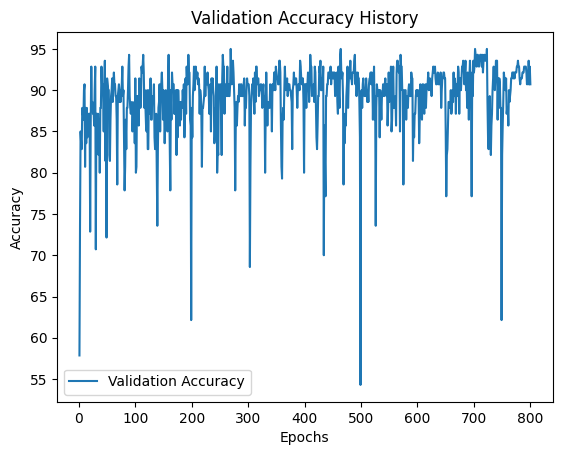

In [ ]:
epochs = range(1, 800+1, 1)

NUM_EPOCH
# plt.plot(epochs, train_acc_history, label='Training Accuracy')
plt.plot(epochs, val_acc_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy History')
plt.legend()
plt.show()

# 測試模型在test的表現

In [ ]:
all_scores = []
all_labels = []
all_praboility = []
# 計算：模型在test資料上的正確性
acc_count_test = 0
model.eval()
with torch.no_grad():
  for x_score_test, y_score_test in mini_test:
    x_score_test = x_score_test.to(device)
    y_score_test = y_score_test.to(device)
    score_test = model(x_score_test)
    probabilities = torch.softmax(score_test, dim=1)

    predictions=score_test.max(1)[1]
    acc = predictions.eq(y_score_test).sum().item()
    acc_count_test += acc


    # 留存score & label數據
    all_scores.append(predictions)
    all_labels.append(y_score_test)
    all_praboility.append(probabilities)
  test_acc_value = (acc_count_test/len(test_data))*100
  print(f"Epoch:{num_iters+1}：測試資料正確率={np.round(test_acc_value, 2)}%\n")


Epoch:802：測試資料正確率=92.86%



In [ ]:
from sklearn.metrics import confusion_matrix

all_scores = torch.cat(all_scores, dim=0)
all_labels = torch.cat(all_labels, dim=0)
all_praboility = torch.cat(all_praboility, dim=0)

all_scores = all_scores.cpu().numpy()
all_labels = all_labels.cpu().numpy()
all_praboility = all_praboility.cpu().numpy()

In [ ]:
# 繪製混淆矩陣-比例版
conf_matrix = confusion_matrix(all_labels, all_scores, normalize='true') # 顯示佔比
plt.figure(figsize=(8, 6))
num_classes = ['Portrait', 'Midjourney', 'SD', 'Bing']
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=num_classes, yticklabels=num_classes, fmt='.3f')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

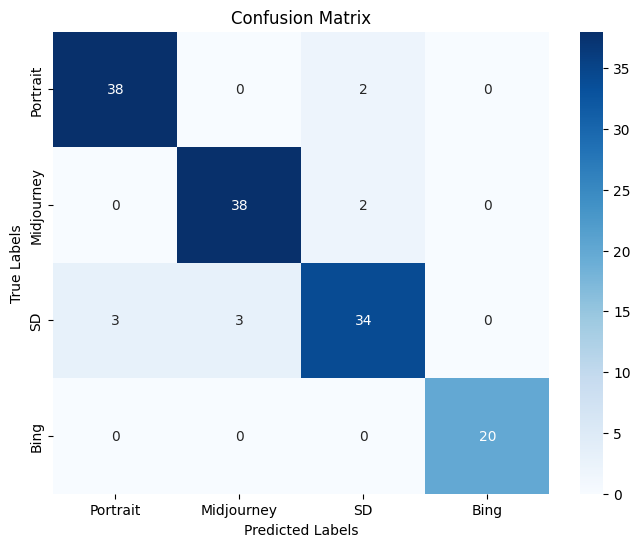

In [ ]:
from sklearn.metrics import confusion_matrix

all_scores = torch.cat(all_scores, dim=0)
all_labels = torch.cat(all_labels, dim=0)
all_praboility = torch.cat(all_praboility, dim=0)

all_scores = all_scores.cpu().numpy()
all_labels = all_labels.cpu().numpy()
all_praboility = all_praboility.cpu().numpy()

# 繪製混淆矩陣-數量版
conf_matrix = confusion_matrix(all_labels, all_scores)
plt.figure(figsize=(8, 6))
num_classes = ['Portrait', 'Midjourney', 'SD', 'Bing']
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=num_classes, yticklabels=num_classes)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
all_scores_binary = [0 if value==0 else 1 for value in all_scores]
all_labels_binary = [0 if value==0 else 1 for value in all_labels]

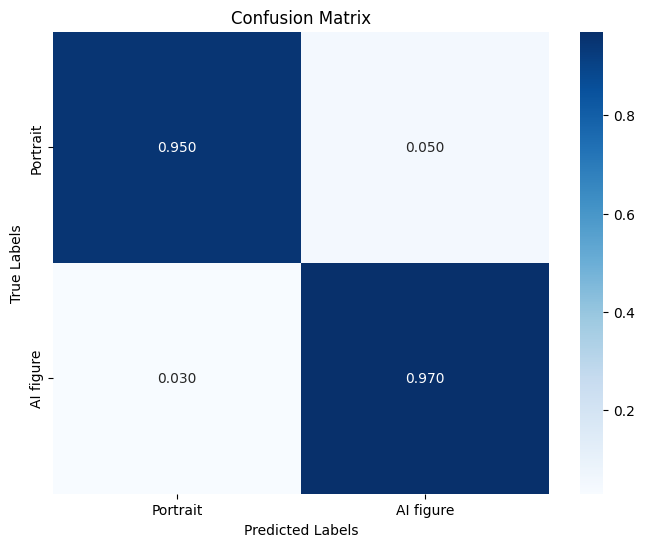

In [ ]:
# 繪製混淆矩陣-比例版-二分類版本
conf_matrix = confusion_matrix(all_labels_binary, all_scores_binary, normalize='true') # 顯示佔比
plt.figure(figsize=(8, 6))
num_classes = ['Portrait', 'AI figure']
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=num_classes, yticklabels=num_classes, fmt='.3f')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# # 保存模型權重
torch.save(resnet.state_dict(), 'resnet50_finetuned_weights_0325_6_800.pth')
print('Finished Training')

Finished Training


# 繪製錯誤圖片

In [ ]:
test_data_image = dset.ImageFolder('test')

In [ ]:
false_index = np.nonzero(all_scores != all_labels)[0]
print("預測錯誤的數量:", len(false_index))
print(false_index)

預測錯誤的數量: 11
[ 5  7 29 34 60 71 73 80 90 95 98]


In [ ]:
mapping_dict = {0:'portrait', 1:'Midjourney', 2:'stable diffusion', 3:'Bing',}

預測結果：stable diffusion
真實結果：portrait
機率：
 portrait：23.114502429962158 
 Midjourney：1.1764993891119957 
 SD：75.70703029632568 
 Bing：0.0019635963326436467 



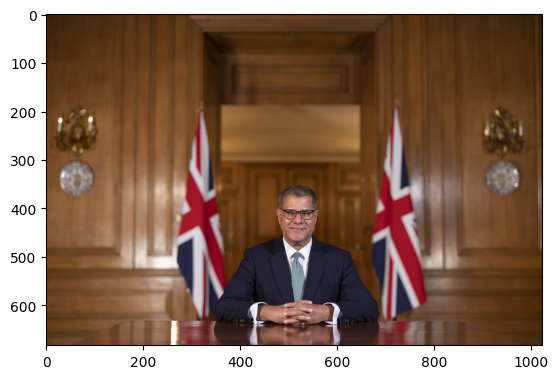

In [ ]:
index_i = false_index[0]
print(f'預測結果：{mapping_dict[all_scores[index_i]]}')
print(f'真實結果：{mapping_dict[all_labels[index_i]]}')
print(f'機率：\n portrait：{all_praboility[index_i][0]*100} \n Midjourney：{all_praboility[index_i][1]*100} \n SD：{all_praboility[index_i][2]*100} \n Bing：{all_praboility[index_i][3]*100} \n')
plt.imshow(test_data_image[index_i][0])

預測結果：stable diffusion
真實結果：portrait
機率：
 portrait：18.899595737457275 
 Midjourney：0.0004684835857915459 
 SD：81.09990954399109 
 Bing：2.1021863005898922e-05 



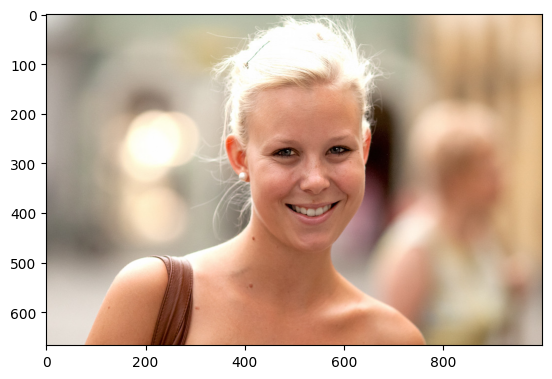

In [ ]:
index_i = false_index[1]
print(f'預測結果：{mapping_dict[all_scores[index_i]]}')
print(f'真實結果：{mapping_dict[all_labels[index_i]]}')
print(f'機率：\n portrait：{all_praboility[index_i][0]*100} \n Midjourney：{all_praboility[index_i][1]*100} \n SD：{all_praboility[index_i][2]*100} \n Bing：{all_praboility[index_i][3]*100} \n')
plt.imshow(test_data_image[index_i][0])

預測結果：Midjourney
真實結果：portrait
機率：
 portrait：2.2814787924289703 
 Midjourney：97.71849513053894 
 SD：2.8940590368620178e-05 
 Bing：6.757917836441862e-09 



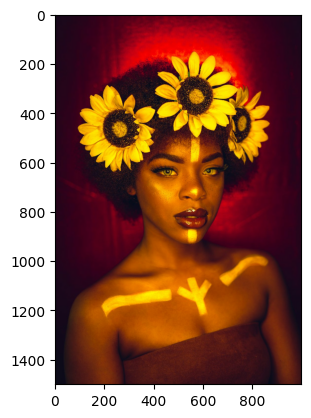

In [ ]:
index_i = false_index[2]
print(f'預測結果：{mapping_dict[all_scores[index_i]]}')
print(f'真實結果：{mapping_dict[all_labels[index_i]]}')
print(f'機率：\n portrait：{all_praboility[index_i][0]*100} \n Midjourney：{all_praboility[index_i][1]*100} \n SD：{all_praboility[index_i][2]*100} \n Bing：{all_praboility[index_i][3]*100} \n')
plt.imshow(test_data_image[index_i][0])

預測結果：Midjourney
真實結果：stable diffusion
機率：
 portrait：0.00040254985833598766 
 Midjourney：99.19890761375427 
 SD：0.7995991967618465 
 Bing：0.0010896929779846687 



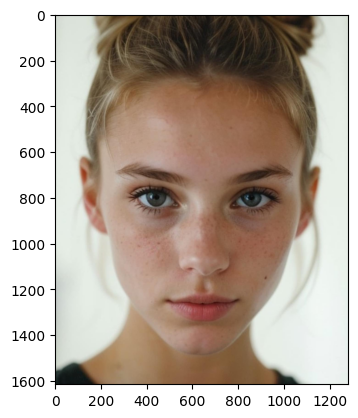

In [ ]:
index_i = false_index[10]
print(f'預測結果：{mapping_dict[all_scores[index_i]]}')
print(f'真實結果：{mapping_dict[all_labels[index_i]]}')
print(f'機率：\n portrait：{all_praboility[index_i][0]*100} \n Midjourney：{all_praboility[index_i][1]*100} \n SD：{all_praboility[index_i][2]*100} \n Bing：{all_praboility[index_i][3]*100} \n')
plt.imshow(test_data_image[index_i][0])

# Saliency maps 初次檢視

# 編號的驗證
+ {0:bing, 1:midjourney, 2:portrait, 3:sd}

In [ ]:
a = dset.ImageFolder('test')

In [ ]:
print(f"編號：{a[0][1]}")
a[0][0]

In [ ]:
print(f"編號：{a[41][1]}")
a[41][0]

In [ ]:
print(f"編號：{a[81][1]}")
a[81][0]

In [ ]:
print(f"編號：{a[121][1]}")
a[121][0]